# Convolutional Neural Networks
Sean Wade

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of the layers.  Another main difference between CNNs and standard DNNs is that neurons are arranged in 3 dimensions, **width, height, and depth**.  Each layer in a CNN takes in an input 3d tensor and output a 3d tensor.  These convolutional layers have many advantages, such as, spare interactions, parameter sharing, and equivariant representations.

## Convolutional Layer

Recall the discrete convolution function is $$ s(t) = (x*w)(t) = \sum_{a=-\infty}^{\infty} x(a)w(t-a)$$

And in the 2 dimensional case we have:

$$S(i, j) = (I * k)(i,j) = \sum_m \sum_n I(m, n)K(i-m, j-n)$$

Convolutional kernels are nothing new to image processing.  This kernels are small matricies that we use for blurring, sharpening, edge detection, and more.

$
\text{Identity: } \quad 
\begin{bmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$

$
\text{Blur: } \qquad  
\begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}
$

$
\text{Sobel (edge): }  
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$

By convolving these kernels across the image we can isolate certain characteristics, or **features**.  A large number at a location after the convolution indicates a large **activation** or response to the kernel.  In the case of the sobel filter a high activation indicates there is an edge present.  This site is an awesome visualization of kernels: http://setosa.io/ev/image-kernels/

CNNs use filters like above for identifying features in 2D space.  However, the magic with CNNs is that these filters are not predetermined, but rather they are learned.  Also these leaned filters are stacked to look for complex, high level features.  For example, instead of just detecting edges we can now detect cars and tires. 

<img  src="images/cnn_filters.png"/>
<img  src="images/activations.png"/>

These filters are small spacially, meaning along the width and height, but always extend to the full depth of the input volume. For example 5x5x3 for a 224x224x3 image.

#### Sparse Connectivity
This comes from making the kernal smaller than the input.   Sparse connectivity reduces the parameters and improves statistical efficiency.  For regular matrix multiplication we have mXn parameters with runtime of O(mn), where a convolution has kXn parameters and O(kn)

<img src='./images/sparse-connectivity.png'>

#### Receptive Field

Even though neurons are sparslly connected, we can still have them see large parts of the input.  This is called the **receptive field**.  Many recent papers have showed that small kernals, like 3x3 small, stacked are better than large kernals because of their receptive field.  By stacking more layers we have less parameters and the same receptive field. This is sumerized well with the following image

<img src='./images/receptive-field.png'>

#### Hyperparameters for Convolution
 - W - Input volume size
 - F - Receptive field size
 - S - Stride
 - P - Amount of 0 padding used
 
 
Output size = $\frac{(W − F+2 P)}{S}+1$

## Fully Connected Layer

A fully connected layer takes the activations and flattens them to behave like a normal layer in a DNN.  These layers are placed at the end of the network.

# Learning MNIST 

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import keras
from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from seansUtils.research import StatsCallback, ModelSummary
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 8)

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Hyper Parameters
TRAIN = False
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
# Load/Prep the Data
(x_train, y_train_num), (x_test, y_test_num) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train_num, 10)
y_test = np_utils.to_categorical(y_test_num, 10)

In [5]:
print('--- THE DATA ---')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

--- THE DATA ---
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Standard DNN

In [6]:
if TRAIN:
    # Define the Type of Model
    model1 = Sequential()

    # Flatten Imgaes to Vector
    model1.add(Reshape((784,), input_shape=(28, 28, 1)))

    # Layer 1
    model1.add(Dense(output_dim=128, init='he_normal', bias=True))
    model1.add(Activation("relu"))

    # Layer 2
    model1.add(Dense(output_dim=10, init='he_normal', bias=True))
    model1.add(Activation("softmax"))

    # Loss and Optimizer
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Store Training Results
    stats = StatsCallback('basic_dnn')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')
    callback_list = [stats, early_stopping]

    # Train the model
    model1.fit(x_train, y_train, nb_epoch=EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test), callbacks=callback_list, verbose=True)

    # Save model and training
    stats = stats.stats_dict
    pickle.dump(stats, open('./load/dnn_stats.p', 'wb'))
    model1.save('./load/dnn.h5')
    
else:
    print('Loading pretrained model...')
    stats = pickle.load(open('./load/dnn_stats.p', 'rb'))
    model1 = keras.models.load_model('./load/dnn.h5')
    print('Model Loaded.')

Loading pretrained model...
Model Loaded.


basic_dnn 
--------------------------

MODEL STATS 
------------
Accuracy:       0.9825
Loss:           0.0726575695478
Parameters:     101770
Training Time:  0:11:11.102419
Epoch Time:     0:00:06.663401


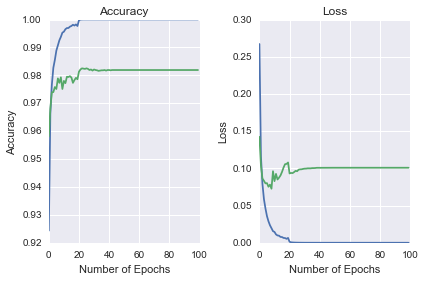

In [7]:
ModelSummary(model1, stats).show()

The standard DNN is quick to fit this small example with good accuracy.  However, it is worth noting that we can not gain much accuracy by going deeper or wider.

<img src='./images/dnn_comparison.png'>

## Vanilla CNN

This is the most basic CNN.  It has 2 convolutional layers and 2 fully connected layers.

In [8]:
if TRAIN:
    # Deine model
    model2 = Sequential()

    # 1st Conv Layer
    model2.add(Convolution2D(32, 3, 3, input_shape=(28, 28, 1)))
    model2.add(Activation('relu'))

    # 2nd Conv Layer
    model2.add(Convolution2D(32, 3, 3))
    model2.add(Activation('relu'))

    # Fully Connected Layer
    model2.add(Flatten())
    model2.add(Dense(128))
    model2.add(Activation('relu'))

    # Prediction Layer
    model2.add(Dense(10))
    model2.add(Activation('softmax'))

    # Loss and Optimizer
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Store Training Results
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')
    stats = StatsCallback('basic_cnn')
    callback_list = [stats, early_stopping]

    # Train the model2
    model2.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, 
              validation_data=(x_test, y_test), callbacks=callback_list)
    
    # Save model2 and Stats
    stats = stats.stats_dict
    pickle.dump(stats, open('./load/basic_cnn_stats.p', 'wb'))
    model2.save('./load/basic_cnn.h5')

else:
    print('Loading pretrained model...')
    stats = pickle.load(open('./load/basic_cnn_stats.p', 'rb'))
    model2 = keras.models.load_model('./load/basic_cnn.h5')
    print('Model Loaded.')

Loading pretrained model...
Model Loaded.


basic_cnn 
--------------------------

MODEL STATS 
------------
Accuracy:       0.9904
Loss:           0.0647522368889
Parameters:     2370282
Training Time:  0:28:25.371154
Epoch Time:     0:00:16.994820


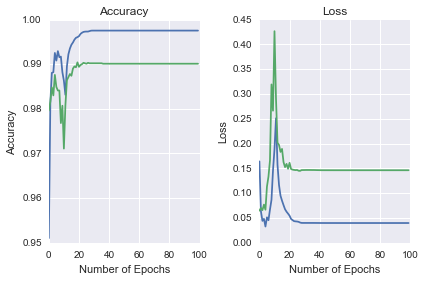

In [9]:
ModelSummary(model2, stats).show()

## CNN + Tricks

This CNN is the same as above plus max pooling and dropout.

### Pooling Layer
​
The function of this layer is to reduce the spacial size of the representation. The benefit of this is three fold: reduce the amount of parameters, lower computation time, and control overfitting.  There are variants like max, average, or overlapping.
​
<img  src="./images/maxpool.jpeg"/>
​
It is worth noting that while this has been standard, a few recent publications have abandoned it.  It could be falling out of favor.

### Batch Normalization

**Input: ** Values of $x$ over a mini-batch: $B = \{x_1,...x_m\}$;

**Output: ** $\{y_i = \text{BN}_{\gamma, \beta}(x_i)\}$

**Algorithm:**

mini-batch mean: $$\qquad \mu_B \leftarrow \frac{1}{m}\sum_{i=1}^m x_i$$

mini-batch variance: $$\qquad \sigma_B^2 \leftarrow \frac{1}{m}\sum_{i=1}^m (x_i - \mu_B)^2$$

normalize: $$\qquad \hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

scale and shift: $$\qquad \gamma \hat{x_i} + \beta \equiv \text{BN}_{\gamma, \beta}(x_i)$$

### Dropout

This is a form of regularization.  At testing time neurons are randomly set to 0.  This makes it so they have no influence on the network.  Doing this randomly makes the network robust to missing information.  At testing time there is no dropout and the activations are scaled by the dropout rate.

<img  src="./images/dropout.jpg"/>

In [10]:
if TRAIN:
    # Deine Model
    model3 = Sequential()

    # 1st Conv Layer
    model3.add(Convolution2D(32, 3, 3, input_shape=(28, 28, 1)))
    model3.add(Activation('relu'))

    # 2nd Conv Layer
    model3.add(Convolution2D(32, 3, 3))
    model3.add(Activation('relu'))

    # Max Pooling
    model3.add(MaxPooling2D(pool_size=(2,2)))
    
    # Dropout
    model3.add(Dropout(0.25))

    # Fully Connected Layer
    model3.add(Flatten())
    model3.add(Dense(128))
    model3.add(Activation('relu'))
    
    # More Dropout
    model3.add(Dropout(0.5))

    # Prediction Layer
    model3.add(Dense(10))
    model3.add(Activation('softmax'))

    # Loss and Optimizer
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Store Training Results
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, verbose=1, mode='auto')
    stats = StatsCallback('better_cnn')
    callback_list = [stats, early_stopping]

    # Train the model
    model3.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, 
              validation_data=(x_test, y_test), callbacks=callback_list)
    
    # Save model and Stats
    stats = stats.stats_dict
    pickle.dump(stats, open('./load/cnn_stats.p', 'wb'))
    model3.save('./load/cnn.h5')

else:
    print('Loading pretrained model...')
    stats = pickle.load(open('./load/cnn_stats.p', 'rb'))
    model3 = keras.models.load_model('./load/cnn.h5')
    print('Model Loaded.')

Loading pretrained model...
Model Loaded.


cnn 
--------------------------

MODEL STATS 
------------
Accuracy:       0.9934
Loss:           0.0364236652162
Parameters:     600810
Training Time:  0:25:05.621819
Epoch Time:     0:00:14.983687


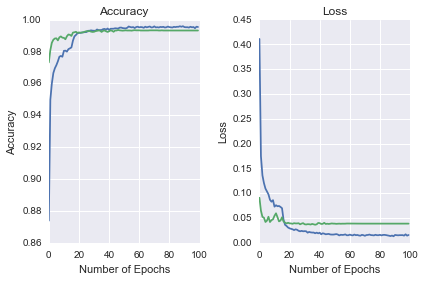

In [11]:
ModelSummary(model3, stats).show()

## How well did we learn?

This confusion matrix shows which numbers are hard to tell apart, like 7 and 2.

In [12]:
y_hat = model3.predict_classes(x_test)
pd.crosstab(y_hat, y_test_num)

10000/10000 [==============================] - 10s    


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,977,0,1,0,0,0,3,0,1,1
1,0,1132,0,0,0,0,4,1,0,0
2,0,2,1027,1,0,0,0,6,4,0
3,0,0,0,1006,0,6,0,0,1,0
4,0,0,1,0,977,0,1,0,0,5
5,0,0,0,2,0,885,2,0,0,2
6,1,1,0,0,3,1,947,0,1,0
7,1,0,3,0,0,0,0,1018,1,2
8,1,0,0,1,0,0,1,1,964,1


Now lets actually see which images were misclassified.

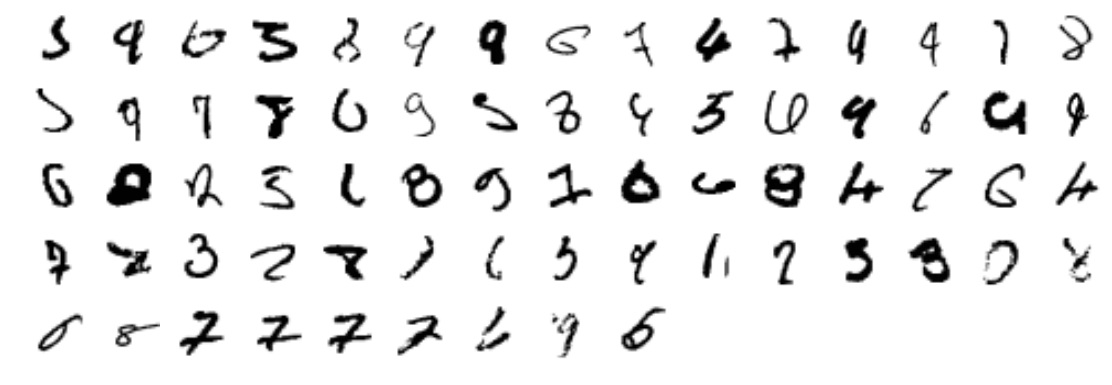

In [13]:
test_wrong = [im for im in zip(x_test, y_hat, y_test_num) if im[1] != im[2]]
plt.figure(figsize=(15, 15))
for ind, val in enumerate(test_wrong):
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.subplot(15, 15, ind + 1)
    im = 1 - val[0].reshape((28,28))
    plt.axis("off")
    plt.imshow(im, cmap='gray')

## Data Augmentation

We can see from training these models that we quickly overfit.  This is because the MNIST dataset is so small.  A very common solution to this is **data augmentation**.  This is done by randomly permuting and changing our data.  This makes it much more difficult for the model to simply memorize the data.  There are many different ways to do this, like rotation, translation, flipping, and others.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Prepare the generator
datagen.fit(x_train)

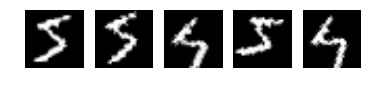

In [15]:
gen = datagen.flow(x_train[:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze(), cmap='gray')
    plt.plot()

In [16]:
# Fit the model with generated data
if TRAIN:
    model.fit_generator(datagen.flow(x_train, y_train,
                        batch_size=BATCH_SIZE),
                        samples_per_epoch=x_train.shape[0],
                        nb_epoch=EPOCHS,
                        validation_data=(x_test, y_test))
else:
    print('Loading pretrained model...')
    stats = pickle.load(open('./load/cnn_augment_stats.p', 'rb'))
    model3 = keras.models.load_model('./load/cnn_augment.h5')
    print('Model Loaded.')

Loading pretrained model...
Model Loaded.


Better CNN with Data Augmentation 
--------------------------

MODEL STATS 
------------
Accuracy:       0.9918
Loss:           0.0259086920658
Parameters:     600810
Training Time:  1:56:45.539563
Epoch Time:     0:00:23.331572


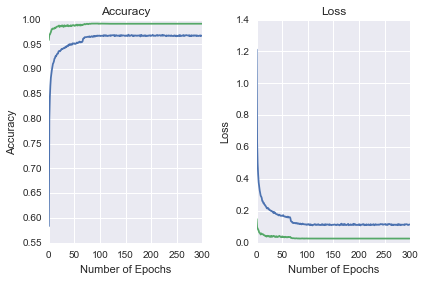

In [17]:
ModelSummary(model3, stats).show()

## CIFAR-10

MNIST is easy, lets ramp it up.  The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.  This is the smallest, most manageable photo classification data set.  It is a standard for many basic models.

In [18]:
# Load/Prep data
(x_train, y_train_num), (x_test, y_test_num) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = np_utils.to_categorical(y_train_num, 10)
y_test = np_utils.to_categorical(y_test_num, 10)

In [19]:
print('X_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


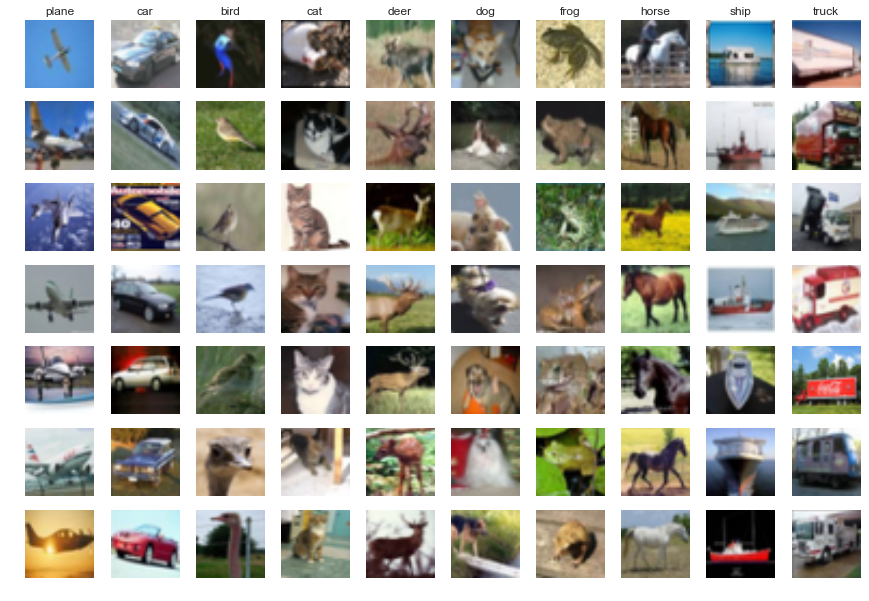

In [20]:
# Visualize some examples from the dataset.
plt.rcParams['figure.figsize'] = (15, 10)
plt.figure(figsize=(15, 10))
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train_num == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
            
plt.show()

In [21]:
if TRAIN:
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Store Training Results
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, verbose=1, mode='auto')
    stats = StatsCallback('cifar_cnn')
    callback_list = [stats, early_stopping]
    
    # Train the Model
    model.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, 
              validation_data=(x_test, y_test), callbacks=callback_list)
    
    # Save Model and Stats
    stats = stats.stats_dict
    pickle.dump(stats, open('./load/cifar_cnn_stats.p', 'wb'))
    model.save('./load/cifar_cnn.h5')

else:
    print('Loading pretrained model...')
    stats = pickle.load(open('./load/cifar_cnn_stats.p', 'rb'))
    model = keras.models.load_model('./load/cifar_cnn.h5')
    print('Model loaded.')

Loading pretrained model...
Model loaded.


Cifar CNN 
--------------------------

MODEL STATS 
------------
Accuracy:       0.7859
Loss:           0.713164025259
Parameters:     1250858
Training Time:  0:37:15.300031
Epoch Time:     0:00:22.337144


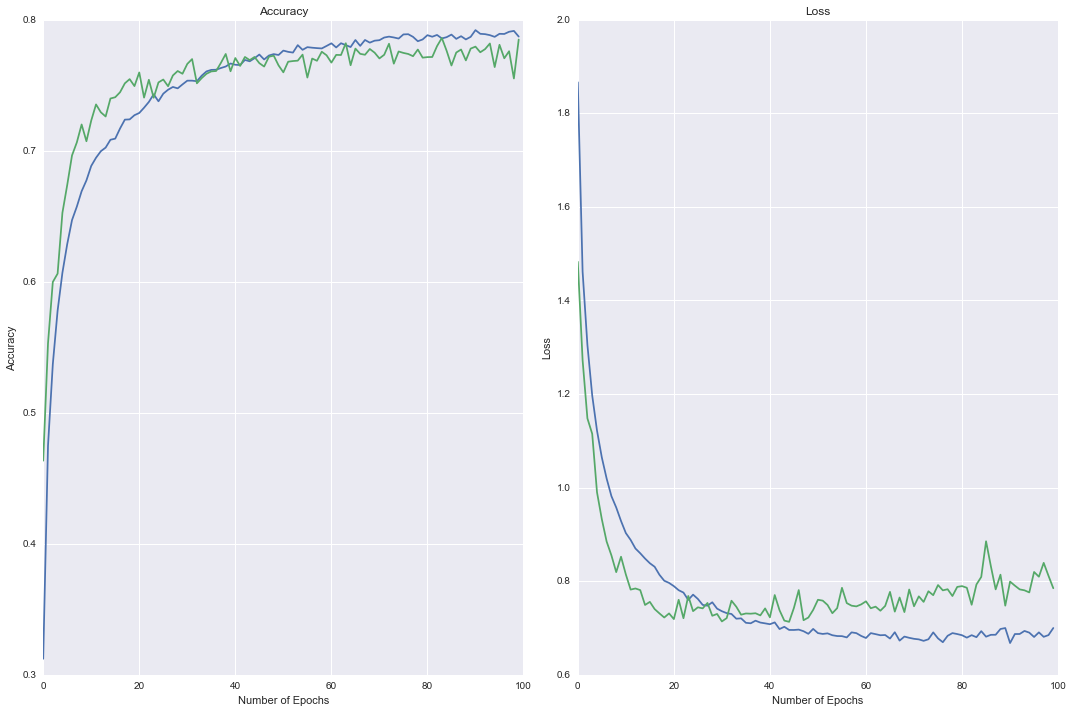

In [22]:
ModelSummary(model, stats).show()

## CNN Architectures

<img src="./images/full_net.png">


<img src="./images/vgg.png">

There are several standard architectures that are legendary (standard and influential).

#### AlexNet
- Trained the network on ImageNet data
- Used ReLU for the nonlinearity functions (Found to decrease training time as ReLUs are several times faster than the conventional tanh function).
- Used data augmentation techniques that consisted of image translations, horizontal reflections, and patch extractions.
- Implemented dropout layers in order to combat the problem of overfitting to the training data.
- Trained the model using batch stochastic gradient descent, with specific values for momentum and weight decay.
- Trained on two GTX 580 GPUs for five to six days.

#### ZF Net
- Very similar architecture to AlexNet, except for a few minor modifications.
- Instead of using 11x11 sized filters in the first layer (which is what AlexNet implemented), ZF Net used filters of size 7x7 and a decreased stride value. The reasoning behind this modification is that a smaller filter size in the first conv layer helps retain a lot of original pixel information in the input volume. A filtering of size 11x11 proved to be skipping a lot of relevant information, especially as this is the first conv layer.
- Used ReLUs for their activation functions, cross-entropy loss for the error function, and trained using batch stochastic gradient descent.
- Trained on a GTX 580 GPU for twelve days.
- Developed a visualization technique named Deconvolutional Network, which helps to examine different feature activations and their relation to the input space. Called “deconvnet” because it maps features to pixels (the opposite of what a convolutional layer does).

#### VGG Net
- The use of only 3x3 sized filters is quite different from AlexNet’s 11x11 filters in the first layer and ZF Net’s 7x7 filters. The authors’ reasoning is that the combination of two 3x3 conv layers has an effective receptive field of 5x5. This in turn simulates a larger filter while keeping the benefits of smaller filter sizes. One of the benefits is a decrease in the number of parameters. Also, with two conv layers, we’re able to use two ReLU layers instead of one.
- 3 conv layers back to back have an effective receptive field of 7x7.
- As the spatial size of the input volumes at each layer decrease (result of the conv and pool layers), the depth of the volumes increase due to the increased number of filters as you go down the network.
- Interesting to notice that the number of filters doubles after each maxpool layer. This reinforces the idea of shrinking spatial dimensions, but growing depth.
- Used scale jittering as one data augmentation technique during training.
- Used ReLU layers after each conv layer and trained with batch gradient descent.
- Trained on 4 Nvidia Titan Black GPUs for two to three weeks.

#### GoogLeNet
- Used 9 Inception modules in the whole architecture, with over 100 layers in total.
- No use of fully connected layers! They use an average pool instead, to go from a 7x7x1024 volume to a 1x1x1024 volume. This saves a huge number of parameters.
- Uses 12x fewer parameters than AlexNet.
- During testing, multiple crops of the same image were created, fed into the network, and the softmax probabilities were averaged to give us the final solution.
- Trained on “a few high-end GPUs within a week”.

#### ResNet
- 152 layers…
- Interesting note that after only the first 2 layers, the spatial size gets compressed from an input volume of 224x224 to a 56x56 volume.
- Authors claim that a naïve increase of layers in plain nets result in higher training and test error (Figure 1 in the paper).
- The group tried a 1202-layer network, but got a lower test accuracy, presumably due to overfitting.
- Trained on an 8 GPU machine for two to three weeks.

## Useful Links:
Interactive Demo:
- http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html
- http://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html

Visualizing Activations:
- https://www.youtube.com/watch?v=AgkfIQ4IGaM

Sources:

[1] http://cs231n.github.io/convolutional-networks/

[2] https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/

[3] http://www.deeplearningbook.org/contents/convnets.html